In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io
from astropy.stats.circstats import circcorrcoef
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from modelUtils import wrap_180, wrap_360, rot, scale_180_from_360, calc_sweep_times
from hdf_utils import unpack_hdf, Workspace
from scalebars import *
import deconv

from SacNetwork import SacNetwork
# import balance_configs as configs
import sac_mode_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
# %matplotlib notebook
%matplotlib widget
# %matplotlib qt
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams['svg.fonttype'] = 'none'  # don't save font as paths (assumes font present on machine)

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"

# TODO:
**timing offsets between EI for each direction:**
- collect input locations for EI synapses at each rho level
- calculate the time delta between E and I
- how does this change over direction?

In [4]:
model_path = os.path.join(base_path, "sanity")
fig_path = os.path.join(model_path, "figs") 
os.makedirs(fig_path, exist_ok=True)

dir_labels = np.array([225, 270, 315, 0, 45, 90, 135, 180])
circle = np.radians([0, 45, 90, 135, 180, 225, 270, 315, 0])
dir_rads = np.radians(dir_labels)
wrap_circ = lambda ds: np.concatenate((ds, [ds[0]]))
dirs_180 = np.array([ana.scale_180_from_360(d) for d in dir_labels])
dir_sort = np.argsort(dir_labels)
dir_180_sort = np.argsort(dirs_180)
dirs_sorted = dir_labels[dir_sort]
dirs_180_sorted = dirs_180[dir_sort]
circ_180 = np.concatenate((dirs_180_sorted, [-dirs_180_sorted[0]]))

# conf = configs.sac_mode_config()
conf = configs.decr_weight()
probs = {
    t: {
        "null": conf["synprops"][t]["null_prob"],
        "pref": conf["synprops"][t]["pref_prob"],
    }
    for t in ["E", "I"]
}
conf["sac_uniform_dist"] = {0: False, 1: False}  # unused dummy value
conf["sac_shared_var"] = 30  # unused dummy value
conf["sac_theta_vars"] = {"E": 60, "I": 60}  # unused dummy value
conf["sac_theta_mode"] = "experimental"  # used (supercedes above settings)

Average GABA synapse count: 172.24


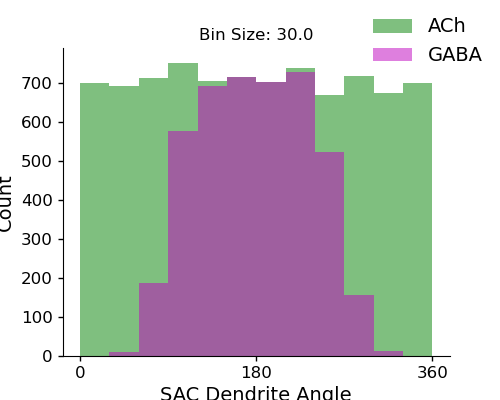

In [5]:
hist_conf = copy.deepcopy(conf)
hist_conf["seed"] = 4
hist_conf["sac_theta_mode"] = "experimental"
hist_nets = 25
angle_hist_fig, angle_hist_ax = ana.sac_angle_distribution(
    hist_conf, rho=1, n_nets=hist_nets, bins=[12], incl_yticks=True, figsize=(5, 4))
name = os.path.join(fig_path, "angle_hist_seed%i_%inets" % (hist_conf["seed"], hist_nets))
for ext in [".png", ".svg"]:
    angle_hist_fig.savefig(name + ext, bbox_inches="tight")

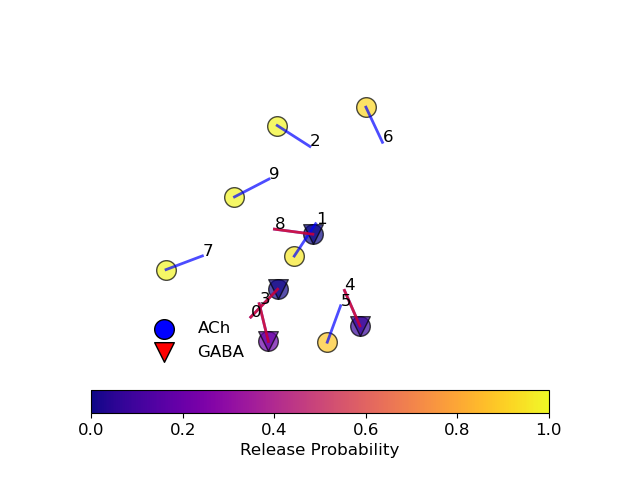

In [6]:
rho = 1.
stim_angle = 0
n_syn = 10
seed = 13
show_plex = True

rng = np.random.default_rng()
syn_locs = rng.uniform(low=0, high=150, size=(n_syn, 2)) + np.array([0, 20])
sample_net = SacNetwork(
    syn_locs,
    probs,
    rho,
    conf["sac_uniform_dist"],
    conf["sac_shared_var"],
    conf["sac_theta_vars"],
    conf["sac_gaba_coverage"],
    dir_labels,
    rng,
    offset=conf["sac_offset"],
    theta_mode=conf["sac_theta_mode"],
    cell_pref=0,
    n_plexus_ach=0,
)

sweep_times = calc_sweep_times(
    sample_net.origin,
    dir_rads,
    conf["light_bar"],
    syn_locs,
    sample_net,
    {"NMDA": [0] * len(dir_labels)},
)

over_fig, over_ax = plt.subplots(1)
ana.plot_dends_overlay(
    over_fig,
    over_ax,
    syn_locs,
    sample_net.bp_locs,
    sample_net.probs,
    dir_labels,
    stim_angle=stim_angle,
    n_syn=n_syn,
    dsgc_alpha=0,
    sac_thickness=2,
    sac_marker_size=200,
    syn_choice_seed=seed,
    show_plex=show_plex,
    # ach_color="green",
    # gaba_color="cyan",
    ach_color="blue",
    gaba_color="red",
    ach_edge="black",
    gaba_edge="black",
    # ach_edge="blue",
    # gaba_edge="red",
    syn_number_size=12,
)
#6 26 37
over_fig.tight_layout()

In [7]:
syn_idx = 0
stim_angle_idx = np.argwhere(dir_labels == stim_angle)[0][0]
print("sac net origin = %s" % str(sample_net.origin))
print("relative start pos = %s" % str(conf["light_bar"]["rel_start_pos"]))
print("syn #%i bp loc = %s" % (syn_idx, str(sample_net.bp_locs["E"][0])))
print("syn #%i theta = %s" % (syn_idx, str(sample_net.thetas["E"][syn_idx])))
print("syn #%i activation time for %s deg motion = %f" % (
    syn_idx, str(stim_angle), sweep_times[stim_angle_idx][0]["E"]))
print("syn #%i probability for %s deg motion = %f" % (
    syn_idx, str(stim_angle), sample_net.probs["E"][syn_idx, stim_angle_idx]))

sac net origin = (58.27575061252089, 97.97760006355105)
relative start pos = [-150    0]
syn #0 bp loc = [67.30616639 48.16213139]
syn #0 theta = 226.04484237940392
syn #0 activation time for 0 deg motion = 159.030416
syn #0 probability for 0 deg motion = 0.012182


In [8]:
def simple_calc_sweep_times(
    locs, # shape (N, 2 [EI], 2 [XY])
    origin,
    vel=1.0,
    rel_start=np.array([-150, 0]),
    rel_end=np.array([150, 0]),
):
    times = {}  # dir -> syn -> trans
    times = np.zeros((len(dir_rads), locs.shape[0], 2)) # shape (8 [dir], N, 2 [EI])
    for i, r in enumerate(dir_rads):
        line_a = rot(r, rel_start) + origin
        line_b = rot(r, rel_end) + origin
        for syn in range(locs.shape[0]):
            for j in range(2):
                dist = project_onto_line(line_a, line_b, locs[syn][j])[0]
                times[i, syn, j] = dist / vel
                
    return times

In [9]:
n_syns = 3000
rho_steps = 50
rhos = np.arange(rho_steps + 1) / rho_steps 

thetas, deltas, abs_deltas, dir_probs, times, has_gaba = [{} for _ in range(6)]
corrs, mean_abs_deltas = [], []

rng = np.random.default_rng()

for rho in rhos:
    sac_net = SacNetwork(
        np.zeros((n_syns, 2)),
        probs,
        rho,
        conf["sac_uniform_dist"],
        conf["sac_shared_var"],
        conf["sac_theta_vars"],
        conf["sac_gaba_coverage"],
        dir_labels,
        rng,
        offset=conf["sac_offset"],
        theta_mode=conf["sac_theta_mode"],
        cell_pref=0,
        n_plexus_ach=0,
    )
    # n = np.sum(sac_net.gaba_here)
    has_gaba[rho] = sac_net.gaba_here
    n = len(sac_net.gaba_here)
    ts = np.zeros((n, 2))
    ts[:, 0] = sac_net.thetas["E"]
    ts[:, 1] = sac_net.thetas["I"]
    thetas[rho] = ts
    paired_ts = ts[sac_net.gaba_here, :]
    corrs.append(circcorrcoef(np.radians(paired_ts[:, 0]), np.radians(paired_ts[:, 1])))
    deltas[rho] = np.vectorize(wrap_180)(paired_ts[:, 0] - paired_ts[:, 1])
    abs_deltas[rho] = np.abs(deltas[rho])
    mean_abs_deltas.append(np.mean(abs_deltas[rho]))
    locs = np.zeros((n, 2, 2))
    locs[:, 0, :] = sac_net.bp_locs["E"]
    locs[:, 1, :] = sac_net.bp_locs["I"]
    times[rho] = simple_calc_sweep_times(locs, sac_net.origin)
    dir_probs[rho] = np.zeros((n, 8, 2))
    dir_probs[rho][:, :, 0] = sac_net.probs["E"]
    dir_probs[rho][:, :, 1] = sac_net.probs["I"]

corrs = np.array(corrs)

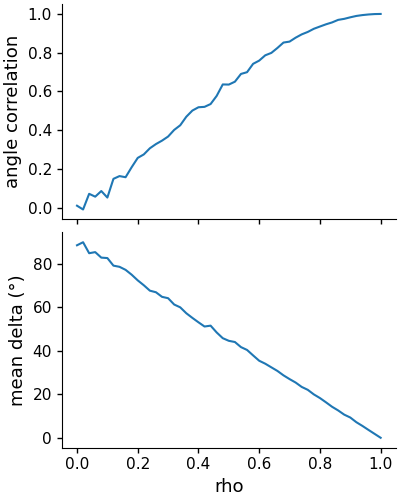

In [10]:
real_corr_fig, real_corr_ax = plt.subplots(2, 1, sharex=True, figsize=(4, 5))
real_corr_ax[0].plot(rhos, corrs)
real_corr_ax[0].set_ylabel("angle correlation", fontsize=13)
real_corr_ax[1].plot(rhos, mean_abs_deltas)
real_corr_ax[1].set_ylabel("mean delta (°)", fontsize=13)
real_corr_ax[-1].set_xlabel("rho", fontsize=13)
real_corr_fig.set_layout_engine("compressed")
clean_axes(real_corr_ax)
for ext in ["png", "svg"]:
    real_corr_fig.savefig(os.path.join(fig_path, "angular_rho_vs_real_corr." + ext), bbox_inches="tight")

In [11]:
e_early_thresh = 5.

time_diff = {r: ts[:, has_gaba[r], 1] - ts[:, has_gaba[r], 0] for r, ts in times.items()}
abs_time_diff = {r: np.abs(diffs) for r, diffs in time_diff.items()}
abs_time_diff_sum = {r: np.sum(diffs, axis=1) for r, diffs in abs_time_diff.items()}
e_early_diff_sum = {
    r: np.array([np.sum(d[d > 0.]) for d in diff]) 
    for r, diff in time_diff.items()
}
e_early = {r: (diffs > e_early_thresh) for r, diffs in time_diff.items()}
e_early_sum = {r: np.sum(early, axis=1) for r, early in e_early.items()}
total_prob = {r: np.sum(pr, axis=0) for r, pr in dir_probs.items()}

avg gaba coverage = 0.50


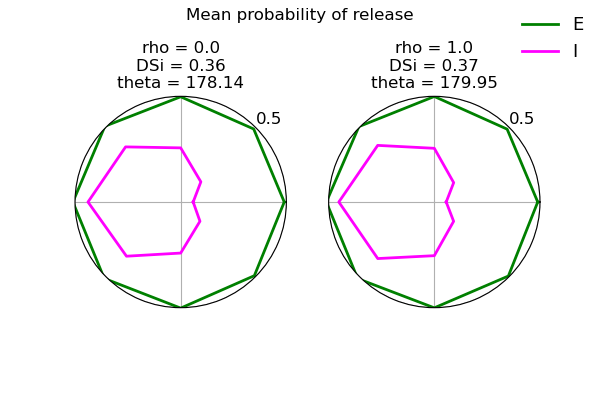

In [12]:
polar_rhos = [0.0, 1.0]
radius_lim = 0.5

circ_total_prob = {r: pr[dir_sort, :] for r, pr in total_prob.items()}
# circ_total_prob = {r: pr[np.argsort(dir_labels), :] for r, pr in total_prob.items()}
circ_total_prob = {
    r: np.concatenate([pr, np.expand_dims(pr[0], axis=0)], axis=0) 
    for r, pr in circ_total_prob.items()
}
circ_mean_prob = {r: pr / dir_probs[r].shape[0] for r, pr in circ_total_prob.items()}

prob_polar_fig = plt.figure(figsize=(6, 4))
prob_polar_ax = []
for i, r in enumerate(polar_rhos):
    ax = prob_polar_fig.add_subplot(1, len(polar_rhos), i + 1, projection="polar")
    prob_polar_ax.append(ax)
    ax.plot(circle, circ_mean_prob[r][:, 0], c="green", linewidth=2, label="E" if not i else None)
    ax.plot(circle, circ_mean_prob[r][:, 1], c="magenta", linewidth=2, label="I" if not i else None)
    radius = np.max(circ_mean_prob[r]) if radius_lim is None else radius_lim
    dsi, theta = calc_tuning(total_prob[r][:, 1], dir_labels)
    ax.set_title("rho = %s\nDSi = %.2f\ntheta = %.2f" % (str(r), dsi, theta))
    ax.set_rmax(radius)
    ax.set_rticks([radius])
    ax.set_rlabel_position(45)
    ax.set_thetagrids([0, 90, 180, 270])
    ax.set_xticklabels([])
    ax.tick_params(labelsize=12)

prob_polar_fig.suptitle("Mean probability of release")
prob_polar_fig.legend(fontsize=13, frameon=False)

print("avg gaba coverage = %.2f" % (np.mean([np.sum(g) for g in has_gaba.values()]) / n_syns))
for ext in ["png", "svg"]:
    prob_polar_fig.savefig(os.path.join(fig_path, "population_prob_polar." + ext), bbox_inches="tight")

In [13]:
quanta_h5 = "/mnt/Data/prerna_velocity/static_roi_waveforms/quantum_pack.h5"
with h5.File(quanta_h5, "r") as f:
    quantum_pack = unpack_hdf(f)
    
release_rates = quantum_pack["clipped_rates"]
rec_dt = quantum_pack["rec_dt"]
target_rate_dt = 0.001  # 0.0001
bp_inputs = {("sust" if k == "PD" else "trans"): r for k, r in quantum_pack["aligned_recs"].items()}
bp_inputs["sust"] = bp_inputs["sust"] * np.max(bp_inputs["trans"]) / np.max(bp_inputs["sust"])

vrate = deconv.velocity_rate(
    bp_inputs["trans"],
    rec_dt,
    quantum_pack["quantum"],
    1,
    rf=0.06,
    spot=0.2,
    bsln_start=100,
    bsln_end=150,
    step=1,
    offset=0.,
    model_dt=target_rate_dt,
)
vrate = np.clip(vrate, 0.0, np.inf)

_rate = deconv.velocity_rate(
    bp_inputs["trans"],
    rec_dt,
    quantum_pack["quantum"],
    1,
    rf=0.06,
    spot=0.2,
    bsln_start=100,
    bsln_end=150,
    step=1,
    offset=0.,
    model_dt=0.005,
)

vrate_xaxis = np.arange(len(vrate))

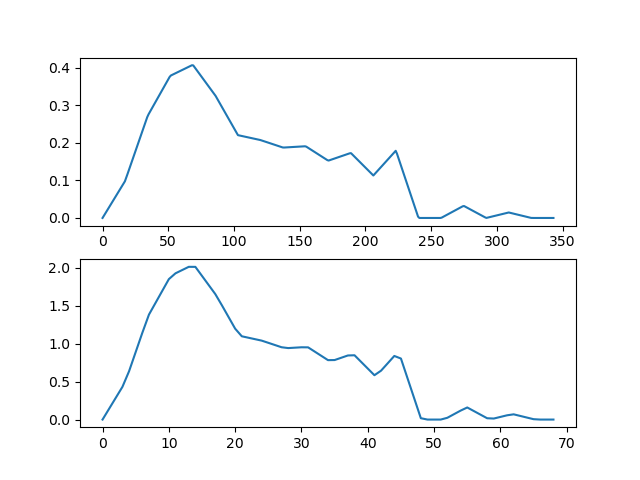

In [14]:
vrate_fig, vrate_ax = plt.subplots(2)
vrate_ax[0].plot(vrate)
vrate_ax[1].plot(_rate)

In [15]:
from deconv import poisson_of_release, sum_quanta
def poisson_shared_base(rng, rate, rho=0.8, i_scale=1, e_scale=0.8):
    inv_rho = 1 - rho
    # inv_rho = 1 - rho**2
    # inv_rho = np.sqrt(1 - rho**2)
    base_psn = poisson_of_release(rng, rate * rho)
    e_psn = np.round(
        e_scale * (base_psn + poisson_of_release(rng, rate * inv_rho))
    ).astype(int)
    i_psn = np.round(
        i_scale * (base_psn + poisson_of_release(rng, rate * inv_rho))
    ).astype(int)
    return base_psn, e_psn, i_psn
    
def poisson_correlation_shared_base(rate, i_scale=1, e_scale=0.8):
    rng = np.random.default_rng()
    base_total, e_total, i_total, corr = [], [], [], []
    for _ in range(10000):
        base_psn, e_psn, i_psn = poisson_shared_base(rng, rate, rho=0.8, i_scale=i_scale, e_scale=e_scale)
        base_total.append(np.sum(base_psn))
        i_total.append(np.sum(i_psn))
        e_total.append(np.sum(e_psn))
        corr.append(np.corrcoef(i_psn - rate * i_scale, e_psn - rate * e_scale)[0][1])

    print(
        "base total = %f\ni total = %f\ne total = %f\n corr = %f\n"
        % (np.mean(base_total), np.mean(i_total), np.mean(e_total), np.mean(corr))
    )
poisson_correlation_shared_base(_rate)

base total = 40.557600
i total = 50.718500
e total = 45.532300
 corr = 0.769664



In [16]:
def poisson_correlation_inhib_base(rate):
    rng = np.random.default_rng()
    rho = 0.6
    inv_rho = 1 - rho
    # inv_rho = 1 - rho**2
    # inv_rho = np.sqrt(1 - rho**2)
    # scale = 0.6
    scale = 1
    e_total, i_total, corr = [], [], []
    for _ in range(10000):
        i_psn = poisson_of_release(rng, rate)
        e_psn = np.round(
            scale * (i_psn * rho + poisson_of_release(rng, rate * inv_rho))
        ).astype(int)
        i_psn = np.round(scale * i_psn).astype(int)

        i_total.append(np.sum(i_psn))
        e_total.append(np.sum(e_psn))
        # corr.append(np.corrcoef(i_psn, e_psn)[0][1])
        corr.append(np.corrcoef(i_psn - np.mean(i_psn), e_psn - np.mean(e_psn))[0][1])

    print(
        "i total = %f\ne total = %f\n corr = %f\n"
        % (np.mean(i_total), np.mean(e_total), np.mean(corr))
    )
    
poisson_correlation_inhib_base(vrate)

i total = 50.832400
e total = 65.819700
 corr = 0.791735



In [17]:
n_syns = 3000
plex_counts = [0, 1, 2, 3, 4]
print_sanity = False

ach_thetas, ach_dir_probs, plex_has_gaba, ach_vec_thetas, ach_vec_dsis = {}, {}, {}, {}, {}
rng = np.random.default_rng()

for n_plex in plex_counts:
    sac_net = SacNetwork(
        np.zeros((n_syns, 2)),
        probs,
        1.0,
        conf["sac_uniform_dist"],
        conf["sac_shared_var"],
        conf["sac_theta_vars"],
        conf["sac_gaba_coverage"],
        dir_labels,
        rng,
        offset=conf["sac_offset"],
        theta_mode=conf["sac_theta_mode"],
        cell_pref=0,
        n_plexus_ach=n_plex,
    )
    plex_has_gaba[n_plex] = sac_net.gaba_here[:]
    ts = np.zeros((n_syns, n_plex + 1))
    ts[:, 0] = sac_net.thetas["E"]
    if print_sanity:
        print("n_plex = %i (primary ACh tuning)" % n_plex)
        print("  GABA synapses: DSi %f, theta %f" 
              % calc_tuning(np.ones(np.sum(plex_has_gaba[n_plex])), sac_net.thetas["E"][plex_has_gaba[n_plex]]))
        no_gaba = (1 - plex_has_gaba[n_plex]).astype(bool)
        print("  GABAless synapses: DSi %f, theta %f" 
              % calc_tuning(np.ones(np.sum(no_gaba)), sac_net.thetas["E"][no_gaba]))
        print("  overall: DSi %f, theta %f" % calc_tuning(np.ones(n_syns), sac_net.thetas["E"]))
    if n_plex:
        ts[:, 1:] = sac_net.thetas["PLEX"]
        ones = np.ones(n_plex + 1)
        ach_vec_dsis[n_plex], ach_vec_thetas[n_plex]  = zip(*(calc_tuning(ones, degs) for degs in ts))
        ach_vec_thetas[n_plex] = np.array(ach_vec_thetas[n_plex])
        ach_vec_dsis[n_plex] = np.array(ach_vec_dsis[n_plex])
    else:
        ach_vec_thetas[0] = ts[:, 0]
        ach_vec_dsis[0] = np.ones(n_syns)
    ach_thetas[n_plex] = ts
    ach_dir_probs[n_plex] = np.zeros((n_syns, 8, n_plex + 1))
    ach_dir_probs[n_plex][:, :, 0] = sac_net.probs["E"]
    if n_plex:
        ach_dir_probs[n_plex][:, :, 1:] = sac_net.probs["PLEX"]

ach_syn_probs = {n: pr.sum(axis=2) for n, pr in ach_dir_probs.items()}
ach_total_prob = {n: pr.mean(axis=0) for n, pr in ach_syn_probs.items()}
circ_ach_total_prob = {n: pr[dir_sort] for n, pr in ach_total_prob.items()}
circ_ach_total_prob = {
    n: np.concatenate([pr, np.expand_dims(pr[0], axis=0)], axis=0) 
    for n, pr in circ_ach_total_prob.items()
}

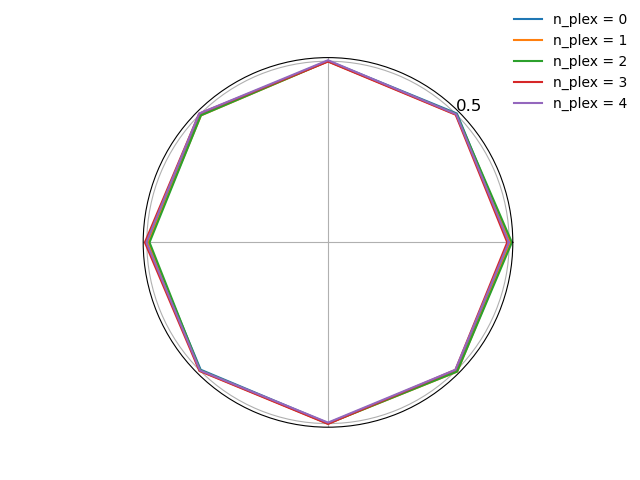

In [18]:
ach_tuning_plex_polar_fig = plt.figure()
ach_tuning_plex_polar_ax = ach_tuning_plex_polar_fig.add_subplot(111, projection="polar")
for n, prs in circ_ach_total_prob.items():
    ach_tuning_plex_polar_ax.plot(circle, prs, label="n_plex = %i" % n)
    
ach_tuning_plex_polar_ax.set_rmax(0.51)
ach_tuning_plex_polar_ax.set_rticks([0.5])
ach_tuning_plex_polar_ax.set_rlabel_position(45)
ach_tuning_plex_polar_ax.set_thetagrids([0, 90, 180, 270])
ach_tuning_plex_polar_ax.set_xticklabels([])
ach_tuning_plex_polar_ax.tick_params(labelsize=12)
ach_tuning_plex_polar_fig.legend(frameon=False)

n_plex 0
  variance 3.985886740706657e-06
  range 0.006218422547851432
n_plex 1
  variance 8.93570585948752e-06
  range 0.008482085326943556
n_plex 2
  variance 1.8303558654209147e-05
  range 0.014906862671030419
n_plex 3
  variance 9.755227318680629e-06
  range 0.010690610353859209
n_plex 4
  variance 4.295036014535394e-06
  range 0.005772388819480445


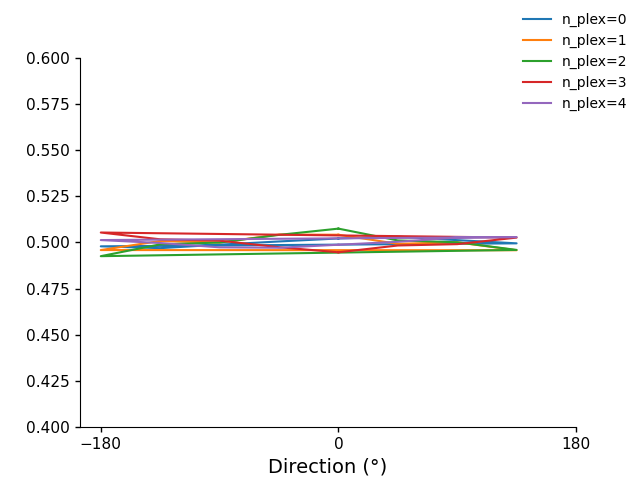

In [19]:
ach_tuning_plex_fig, ach_tuning_plex_ax = plt.subplots(1)
for n, prs in circ_ach_total_prob.items():
    ach_tuning_plex_ax.plot(circ_180, prs, label="n_plex=%i" % n)
    print("n_plex %i\n  variance %s\n  range %s" % (n, np.var(prs[:-1]), np.max(prs) - np.min(prs)))

ach_tuning_plex_ax.set_ylim(0.4, 0.6)
ach_tuning_plex_ax.set_xticks([-180, 0, 180])
ach_tuning_plex_ax.set_xlabel("Direction (°)", fontsize=14)
ach_tuning_plex_fig.legend(frameon=False)
clean_axes(ach_tuning_plex_ax)

== ACh vector tuning at GABA synpases ==
n_plex = 0: DSi 0.601941, theta 179.869752
n_plex = 1: DSi 0.401230, theta -178.729338
n_plex = 2: DSi 0.326474, theta -176.884211
n_plex = 3: DSi 0.279007, theta -172.812772
n_plex = 4: DSi 0.236449, theta 173.453833


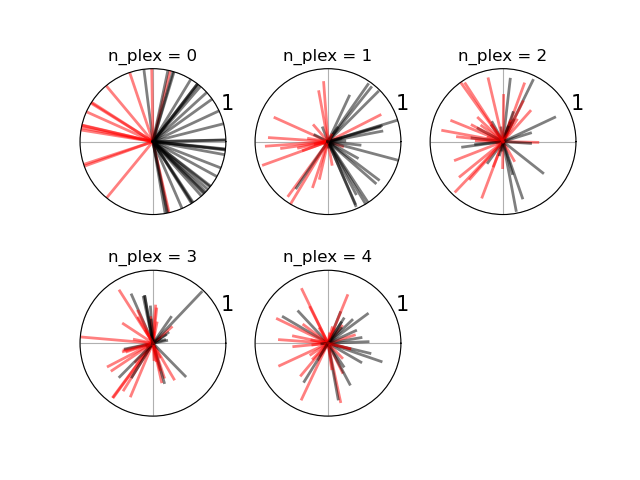

In [20]:
syn_sample = 50
max_rows = 2
show_gabaless = True
n_rows = min(max_rows, len(plex_counts))
n_cols = max(1, int(np.ceil(len(plex_counts) / n_rows)))

ach_synapse_vec_tuning_polar_fig = plt.figure()
synapse_vec_tuning_polars = []
print("== ACh vector tuning at GABA synpases ==")
for i, n_plex in enumerate(plex_counts):
    ax = ach_synapse_vec_tuning_polar_fig.add_subplot(n_rows, n_cols, i + 1, projection="polar")
    synapse_vec_tuning_polars.append(ax)
    dsi, theta = calc_tuning(
        np.ones(np.sum(plex_has_gaba[n_plex])), ach_vec_thetas[n_plex][plex_has_gaba[n_plex]])
    print("n_plex = %i: DSi %f, theta %f" % (n_plex, dsi, theta))
    for j in rng.integers(low=0, high=n_syns, size=syn_sample):
        if plex_has_gaba[n_plex][j] or show_gabaless:
            color = "red" if plex_has_gaba[n_plex][j] else "black"
            theta = np.radians(ach_vec_thetas[n_plex][j])  
            ax.plot(
                [theta, theta],
                [0.0, ach_vec_dsis[n_plex][j]],
                color=color,
                alpha=0.5,
                linewidth=2,
            )
    ax.set_rmax(1.0)
    ax.set_rticks([1.0])
    ax.set_thetagrids([0, 90, 180, 270])
    ax.set_xticklabels([])
    ax.tick_params(labelsize=15)
    ax.set_title("n_plex = %i" % n_plex)

== ACh probability tuning at GABA synpases ==
n_plex = 0: DSi 0.365072, theta 179.837571
n_plex = 1: DSi 0.193191, theta -179.267736
n_plex = 2: DSi 0.124224, theta -175.504137
n_plex = 3: DSi 0.092771, theta -175.586627
n_plex = 4: DSi 0.072152, theta 174.972511


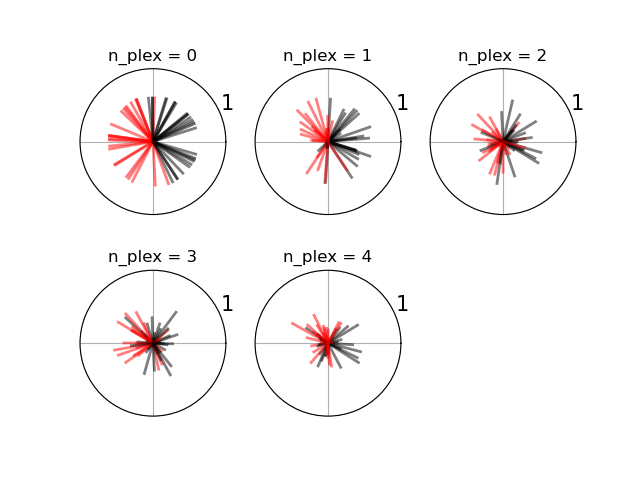

In [21]:
show_mean_arrows = False
ach_synapse_prob_tuning_polar_fig = plt.figure()
synapse_prob_tuning_polars = []
print("== ACh probability tuning at GABA synpases ==")
for i, n_plex in enumerate(plex_counts):
    ax = ach_synapse_prob_tuning_polar_fig.add_subplot(n_rows, n_cols, i + 1, projection="polar")
    synapse_prob_tuning_polars.append(ax)
    mean_dsi, mean_theta = calc_tuning(
        np.sum(ach_syn_probs[n_plex][plex_has_gaba[n_plex]], axis=0), dir_labels)
    print("n_plex = %i: DSi %f, theta %f" % (n_plex, mean_dsi, mean_theta))
    for j in rng.integers(low=0, high=n_syns, size=syn_sample):
        if show_gabaless or plex_has_gaba[n_plex][j]:
            color = "red" if plex_has_gaba[n_plex][j] else "black"
            dsi, theta = calc_tuning(ach_syn_probs[n_plex][j], dir_labels)
            ax.plot(
                [np.radians(theta)] * 2,
                [0.0, dsi],
                color=color,
                alpha=0.5,
                linewidth=2,
            )
            if show_mean_arrows:
                ax.plot(
                    [np.radians(mean_theta)] * 2,
                    [0.0, mean_dsi],
                    color=color,
                    alpha=1,
                    linewidth=3,
                )
    ax.set_rmax(1.0)
    ax.set_rticks([1.0])
    ax.set_thetagrids([0, 90, 180, 270])
    ax.set_xticklabels([])
    ax.tick_params(labelsize=15)
    ax.set_title("n_plex = %i" % n_plex)

original ACh theta = 127.479731
theta from probabilities = 125.800789


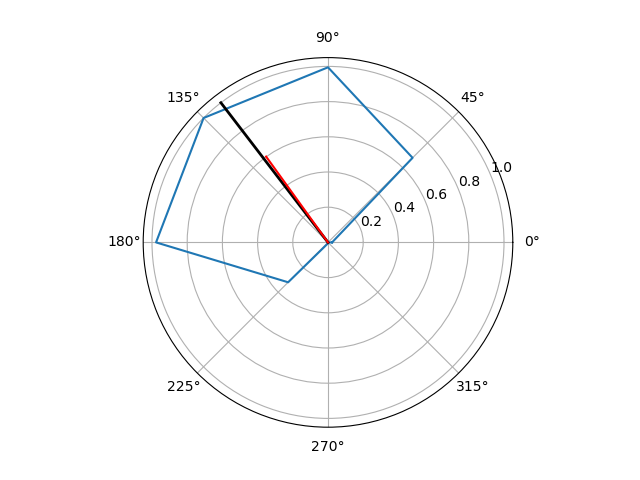

In [22]:
only_with_gaba = True
if only_with_gaba:
    syn = rng.choice(np.argwhere(plex_has_gaba[0])[:, 0])
else:
    syn = rng.integers(low=0, high=n_syns)
    
example_syn_tuning_fig = plt.figure()
example_syn_tuning_ax = example_syn_tuning_fig.add_subplot(111, projection="polar")

example_syn_tuning_ax.plot(circle, wrap_circ(ach_syn_probs[0][syn][dir_sort]), label="probability")
vec_theta = ach_vec_thetas[0][syn]
example_syn_tuning_ax.plot(
    [np.radians(vec_theta)] * 2, [0.0, 1.0], color="black", linewidth=2, label="og angle")
dsi, theta = calc_tuning(ach_syn_probs[0][syn], dir_labels)
example_syn_tuning_ax.plot([np.radians(theta)] * 2, [0, dsi], color="red", label="")

scaled = (" (%f)" % scale_180_from_360(vec_theta)) if vec_theta > 180 else ""
print("original ACh theta = %f%s" % (ach_vec_thetas[0][syn], scaled))
print("theta from probabilities = %f" % theta)

SARIMAXParams(exog=[nan], ar=[-1. -1. -1. -1. -1.], sigma2=nan)


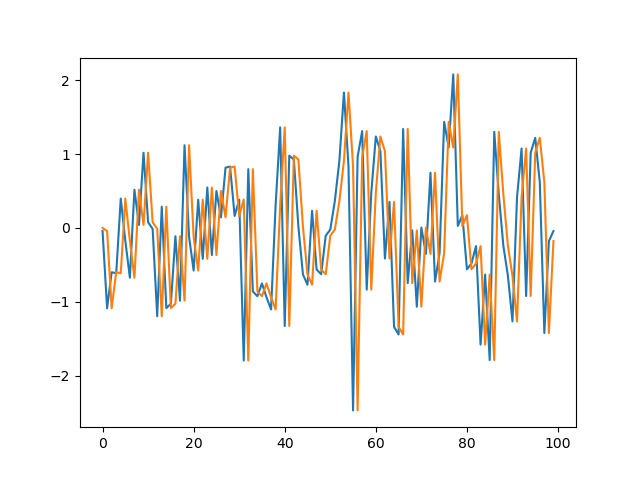

In [23]:
# arm = ARIMA(vrate, order=(1, 0, 0))
# arm = ARIMA(_rate, order=(1, 0, 0))
op = 5
# arm = ARIMA(np.ones(len(_rate)), order=(op, 0, 0))
arm = ARIMA(_rate, order=(op, 0, 0))
arm.fit()
print(arm._params)

arima_fig, arima_ax = plt.subplots(1)
# arima_ax.plot(arm.simulate(arm._params, len(vrate)))
# arima_ax.plot(_rate)
shocks = rng.normal(size=100)
arima_ax.plot(shocks)
# arima_ax.plot(arm.simulate(rng.normal(size=op + 2), 100, state_shocks=shocks))
arima_ax.plot(arm.simulate(np.zeros(op + 2), 100, state_shocks=shocks))
# arima_ax.set_ylim(-3, 3)

mvar corr: [[1.         0.81021104]
 [0.81021104 1.        ]]


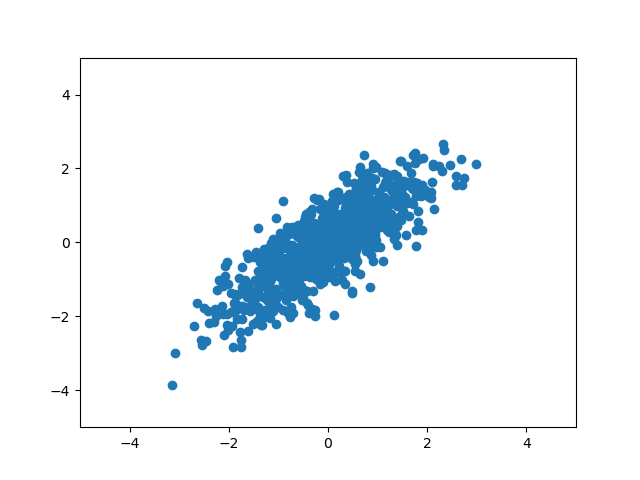

In [24]:
cov = np.array([[1, 0.8], [0.8, 1]])
mvar = rng.multivariate_normal(np.zeros(2), cov, size=1000)
def mvar_fun(size):
    return rng.multivariate_normal(np.zeros(2), cov, size=size)

def mvar_dumb(size):
    return mvar #* 0.5

mvar_fig, mvar_ax = plt.subplots(1)
mvar_ax.scatter(mvar[:, 0], mvar[:, 1])
mvar_ax.set_xlim(-5, 5)
mvar_ax.set_ylim(-5, 5)
print("mvar corr:", np.corrcoef(mvar[:, 0], mvar[:, 1]))

corrcoef: 0.8028144779489984


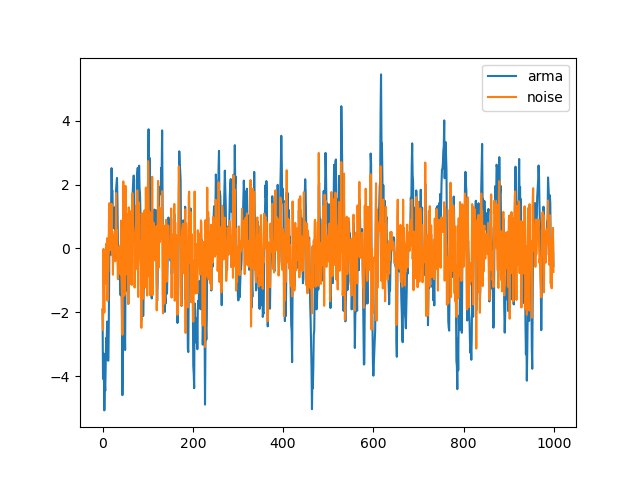

In [25]:
# no way to have innovations or "state_shocks" with this ArmaProcess as they have in R
# https://stats.stackexchange.com/questions/136291/how-do-you-simulate-two-correlated-arp-time-series
# https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/arima.sim
# How complicated is the R code that does this? (no fitting or anything it seems, like is required for
# the ARIMA class in statsmodels). If it is a lot, what about running in R and getting the results into python?
# Gross I know, but I'd like to at least see what it looks like.

# arparams = np.array([.75, -.25])
# maparams = np.array([.65, .355])

arparams = np.array([0.8])
maparams = np.array([0])

# arparams = np.array([0.])
# maparams = np.array([0.8])

ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag

arma_process = sm.tsa.ArmaProcess(ar, ma)
# ss = arma_process.generate_sample(1000, distrvs=mvar_fun)
ss = arma_process.generate_sample(1000, distrvs=mvar_dumb)

arma_fig, arma_ax = plt.subplots(1)
arma_ax.plot(ss[:, 0], label="arma")
# arma_ax.plot(ss[:, 1])
arma_ax.plot(mvar[:, 0], label="noise")
arma_ax.legend()
print("corrcoef:", np.corrcoef(ss[:, 0], ss[:, 1])[0, 1])

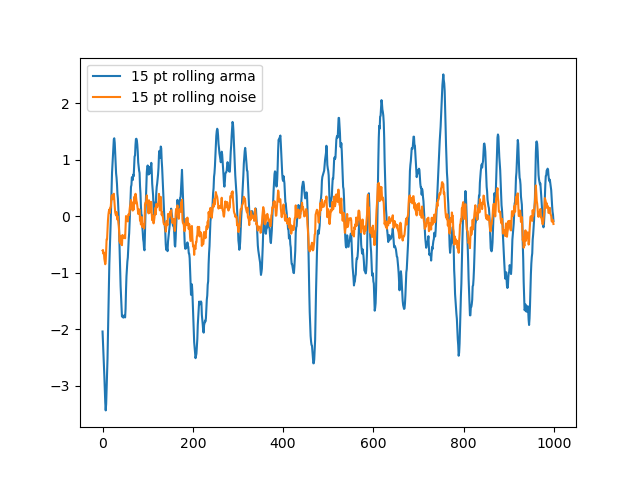

In [26]:
window = 15
roll_fig, roll_ax = plt.subplots(1)
roll_ax.plot(rolling_average(ss[:, 0], n=window), label="%i pt rolling arma" % window)
roll_ax.plot(rolling_average(mvar[:, 0], n=window), label="%i pt rolling noise" % window)
roll_ax.legend()

corrcoef: 0.8711824561304262
clipped corrcoef: 0.8711824561304262


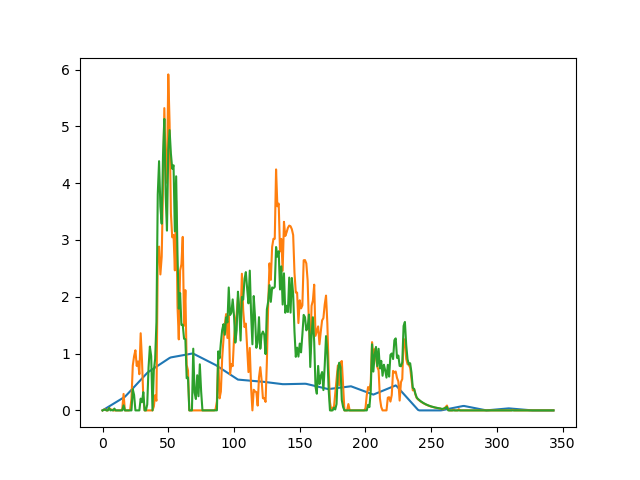

In [27]:
norm_rate = vrate / np.max(vrate)

def rate_mvar_fun(rate, factor):
    scale = rate.reshape(-1, 1) * factor
    def fun(size):
        return rng.multivariate_normal(np.zeros(2), cov, size=size) * scale
    return fun

# arparams = np.array([.75, -.25])
# maparams = np.array([.65, .355])

arparams = np.array([0.9])
maparams = np.array([0.])

# arparams = np.array([0.])
# maparams = np.array([0.9])
# maparams = np.array([0.65, 0.355])

# arparams = np.array([.6, .3])
# maparams = np.array([0, 0])

ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag

innov_scale = 1
arma_process = sm.tsa.ArmaProcess(ar, ma)
ss = arma_process.generate_sample(len(norm_rate), distrvs=rate_mvar_fun(norm_rate, innov_scale))

arma_rate_fig, arma_rate_ax = plt.subplots(1)
arma_rate_ax.plot(norm_rate)
# arma_rate_ax.plot(norm_rate + ss[:, 0])
# arma_rate_ax.plot(norm_rate + ss[:, 1])
# arma_rate_ax.plot(np.clip(norm_rate + ss[:, 0], 0, np.inf))
# arma_rate_ax.plot(np.clip(norm_rate + ss[:, 1], 0, np.inf))
arma_rate_ax.plot(np.clip(ss[:, 0], 0, np.inf))
arma_rate_ax.plot(np.clip(ss[:, 1], 0, np.inf))
# arma_rate_ax.legend()
css = np.clip(ss, 0, np.inf)
print("corrcoef:", np.corrcoef(css[:, 0], css[:, 1])[0, 1])
print("clipped corrcoef:", np.corrcoef(css[:, 0], css[:, 1])[0, 1])

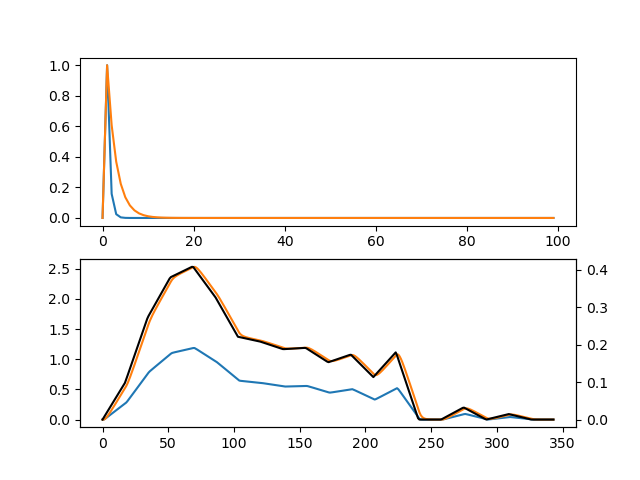

In [28]:
# quanta_xaxis = np.linspace(0, 0.50, 100)
quanta_xaxis = np.arange(100)

ach_biexp = biexp(quanta_xaxis, 0.14 , 0.54, m=1, b=0)
ach_biexp /= np.min(ach_biexp)
gaba_biexp = biexp(quanta_xaxis, 0.14, 2, m=1, b=0)
gaba_biexp /= np.min(gaba_biexp)

ach_ex = np.convolve(norm_rate, ach_biexp, mode="full")[:len(norm_rate)]
gaba_ex = np.convolve(norm_rate, gaba_biexp, mode="full")[:len(norm_rate)]
# ach_ex = np.convolve(norm_rate, np.flip(ach_biexp), mode="same")
# gaba_ex = np.convolve(norm_rate, np.flip(gaba_biexp), mode="same")

trans_ex_fig, trans_ex_ax = plt.subplots(2)
trans_ex_ax[0].plot(quanta_xaxis, ach_biexp)
trans_ex_ax[0].plot(quanta_xaxis, gaba_biexp)
trans_ex_axr = trans_ex_ax[1].twinx()
trans_ex_axr.plot(vrate, color="black")
trans_ex_ax[1].plot(ach_ex)
# trans_ex_ax[1].plot(ach_ex / np.max(ach_ex) * np.max(gaba_ex))
trans_ex_ax[1].plot(gaba_ex)

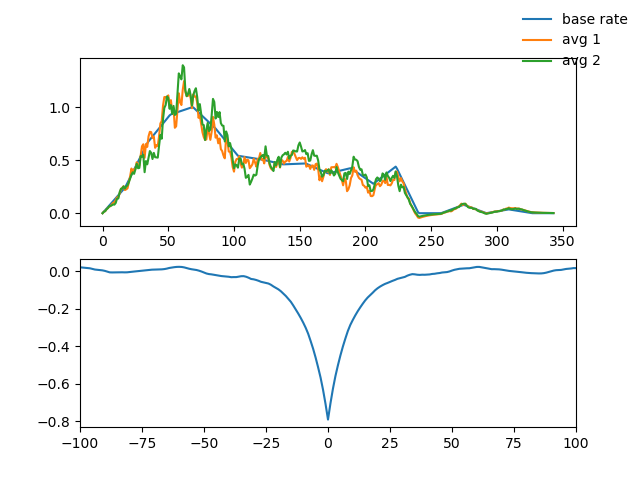

In [29]:
n_trials = 100
recs = np.zeros((n_trials, 2, len(norm_rate)))
xcorrs = np.zeros((n_trials, len(norm_rate) * 2 - 1))
for i in range(n_trials):
    noise = arma_process.generate_sample(len(norm_rate), distrvs=rate_mvar_fun(norm_rate, innov_scale))
    recs[i] = norm_rate + noise.T
    xcorrs[i] = norm_xcorr(noise[:, 0], noise[:, 1] * -1, mode="full")

avg_recs = np.mean(recs, axis=0)
full_xaxis = np.concatenate([np.flip(vrate_xaxis[1:] * -1), vrate_xaxis])

arma_avg_rate_fig, arma_avg_rate_ax = plt.subplots(2)
arma_avg_rate_ax[0].plot(norm_rate, label="base rate")
arma_avg_rate_ax[0].plot(avg_recs[0], label="avg 1")
arma_avg_rate_ax[0].plot(avg_recs[1], label="avg 2")
arma_avg_rate_ax[1].plot(full_xaxis, np.mean(xcorrs, axis=0))

arma_avg_rate_ax[1].set_xlim(-100, 100)
arma_avg_rate_fig.legend(frameon=False)

In [30]:
# Try going here again (forum currently down). There might be answers in here that
# clear up how easy what I want to do is.
# https://www.neuron.yale.edu/phpBB/viewtopic.php?t=2475
# https://web.archive.org/web/20210301141639/https://www.neuron.yale.edu/phpBB/viewtopic.php?t=2475

In [31]:
# def biexp(x, m, t1, t2, b):
#     return m * (np.exp(-x / t1) - np.exp(-x / t2)) + b

# biquant_xaxis = np.linspace(0, (quantum_pts - 1) * dt, 1000)
# biquant = biexp(alpha_xaxis, 1, tau1 / 1000, tau2 / 1000, 0) 
# biquant = biquant / np.min(biquant)

(-100.0, 100.0)

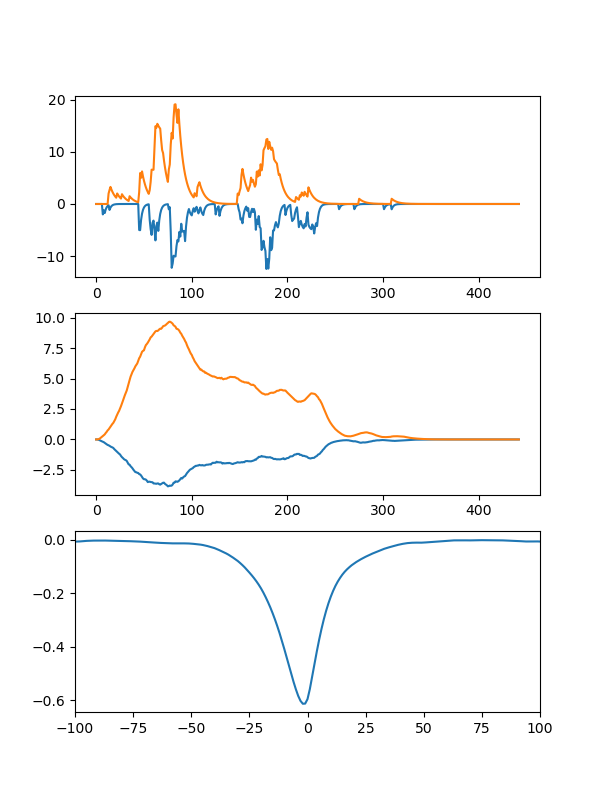

In [45]:
dt = 1
rng = np.random.default_rng()
dummy_psn = poisson_of_release(rng, vrate)
dummy_qsum = sum_quanta(dummy_psn, np.arange(len(dummy_psn)) * dt, ach_biexp, dt)

arma_mode = True
base_scale = 0
innov_scale = 1
arparams = np.array([0.9])
maparams = np.array([0.])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
arma_process = sm.tsa.ArmaProcess(ar, ma)

# ach_biexp = biexp(quanta_xaxis, 0.14 , 0.54, m=1, b=0)
ach_biexp = biexp(quanta_xaxis, 0.14 , 2, m=1, b=0)
# gaba_biexp = biexp(quanta_xaxis, 0.14, 2, m=1, b=0)
gaba_biexp = biexp(quanta_xaxis, 0.14, 6, m=1, b=0)
ach_biexp /= np.min(ach_biexp)
gaba_biexp /= np.min(gaba_biexp)

n_trials = 1000
qsum_recs = np.zeros((n_trials, 2, len(dummy_qsum)))
qsum_xcorrs = np.zeros((n_trials, len(dummy_qsum) * 2 - 1))
qsum_xaxis = np.arange(len(dummy_qsum)) * dt
for i in range(n_trials):
    if arma_mode:
        noise = arma_process.generate_sample(len(norm_rate), distrvs=rate_mvar_fun(norm_rate, innov_scale))
        ach_rate = norm_rate + noise[:, 0]
        gaba_rate = norm_rate + noise[:, 1]
        ach_psn = poisson_of_release(rng, ach_rate)
        gaba_psn = poisson_of_release(rng, gaba_rate)
    else:
        _, ach_psn, gaba_psn = poisson_shared_base(rng, vrate, rho=0.9, i_scale=1, e_scale=1)
    qsum_recs[i, 0] = sum_quanta(ach_psn, np.arange(len(ach_psn)) * dt, ach_biexp, dt) * -1
    qsum_recs[i, 1] = sum_quanta(gaba_psn, np.arange(len(gaba_psn)) * dt, gaba_biexp, dt)

avg_qsum_recs = np.mean(qsum_recs, axis=0)
qsum_rec_resid = qsum_recs - np.expand_dims(avg_qsum_recs, 0)
for i in range(n_trials):
     qsum_xcorrs[i] = norm_xcorr(qsum_rec_resid[i, 0], qsum_rec_resid[i, 1], mode="full")
        
avg_qsum_xcorr = np.mean(qsum_xcorrs, axis=0)

full_qsum_xaxis = np.concatenate([np.flip(qsum_xaxis[1:] * -1), qsum_xaxis])
poisson_qsum_fig, poisson_qsum_ax = plt.subplots(3, figsize=(6, 8))
poisson_qsum_ax[0].plot(qsum_xaxis, qsum_recs[0, 0])
poisson_qsum_ax[0].plot(qsum_xaxis, qsum_recs[0, 1])
poisson_qsum_ax[1].plot(qsum_xaxis, avg_qsum_recs[0])
poisson_qsum_ax[1].plot(qsum_xaxis, avg_qsum_recs[1])
poisson_qsum_ax[2].plot(full_qsum_xaxis, avg_qsum_xcorr)
poisson_qsum_ax[2].set_xlim(-100, 100)